# RFM анализ

Проведите RFM анализ:  
Frequency - количество заказов клиента  
Recency - количество дней с последнего заказа клиента  
Monetary - сумма по всем заказам клиента 

В каждом подсегменте поделите пользователей на 4 класса  

данные:  
InvoiceNo - номер заказа  
CustomerCode - id продавца  
InvoiceDate - дата покупки  
Amount - стоимость заказа  

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set(style='whitegrid', rc={'figure.figsize': (16,6)})

In [2]:
data = pd.read_csv('RFM_ht_data.csv', parse_dates=['InvoiceDate'], dtype={'InvoiceNo': str, 'CustomerCode': str})
data.head()

,InvoiceNo,CustomerCode,InvoiceDate,Amount
0,C0011810010001,19067290,2020-09-01,1716.00
1,C0011810010017,13233933,2020-09-01,1489.74
2,C0011810010020,99057968,2020-09-01,151.47
3,C0011810010021,80007276,2020-09-01,146.72
4,C0011810010024,13164076,2020-09-01,104.00


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332730 entries, 0 to 332729
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceNo     332730 non-null  object        
 1   CustomerCode  332730 non-null  object        
 2   InvoiceDate   332730 non-null  datetime64[ns]
 3   Amount        332730 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 10.2+ MB


In [4]:
data.nunique()

InvoiceNo       332730
CustomerCode    123733
InvoiceDate         30
Amount          143450
dtype: int64

In [5]:
# определим последнюю дату
last_date = data.InvoiceDate.max()
last_date

Timestamp('2020-09-30 00:00:00')

In [6]:
# добавим колонку с разницей в днях
data['DifferenceDays'] = (last_date - data['InvoiceDate']).dt.days

In [7]:
# Сгруппируем датасет для каждого пользователя. 
rfm = data.groupby('CustomerCode').agg({'DifferenceDays': 'min', 'InvoiceNo': 'count', 'Amount': 'sum'})
rfm.rename(columns={'DifferenceDays': 'recency', 'InvoiceNo': 'frequency', 'Amount': 'monetary'}, inplace=True)
rfm.head()

,recency,frequency,monetary
CustomerCode,,,
02213019,19,1,1609.20
02213042,22,3,9685.48
02213071,29,1,415.00
02213088,23,1,305.00
02213092,25,1,1412.88


In [8]:
# Определим границы сегментов
quantiles = rfm.quantile([.25, .5, .75])
quantiles

,recency,frequency,monetary
0.25,2.0,1.0,765.00
0.50,8.0,2.0,1834.48
0.75,16.0,3.0,4008.84


In [9]:
# определяем сегмент
def get_rfm(value, name, quantiles):
    values = quantiles[name].values
    if name == 'recency':
        for i, v in enumerate(values):
            if value <= v:
                return i+1
            if i+1 == len(values):
                return i+2
    else:
        i = len(values)+1
        for v in values:
            if value <= v:
                return i
            if i+1 == len(values):
                return 1
            i -= 1

In [10]:
#  присваиваем значения каждому клиенту
rfm['R'] = rfm['recency'].apply(get_rfm, args=('recency', quantiles))
rfm['F'] = rfm['frequency'].apply(get_rfm, args=('frequency', quantiles))
rfm['M'] = rfm['monetary'].apply(get_rfm, args=('monetary', quantiles))

rfm['RFM'] = rfm.R.map(str) + rfm.F.map(str) + rfm.M.map(str)
rfm.head()

,recency,frequency,monetary,R,F,M,RFM
CustomerCode,,,,,,,
02213019,19,1,1609.20,4,4,3,443
02213042,22,3,9685.48,4,2,1,421
02213071,29,1,415.00,4,4,4,444
02213088,23,1,305.00,4,4,4,444
02213092,25,1,1412.88,4,4,3,443


In [11]:
# сегментируем
rfm_table = rfm.pivot_table(index='R', columns='F', values='monetary', aggfunc=np.median).applymap(int)
rfm_table

F,1,2,3,4
R,,,,
1,5768,2733,1805,729
2,4947,2895,1868,814
3,4179,2770,1813,773
4,3822,2682,1813,859


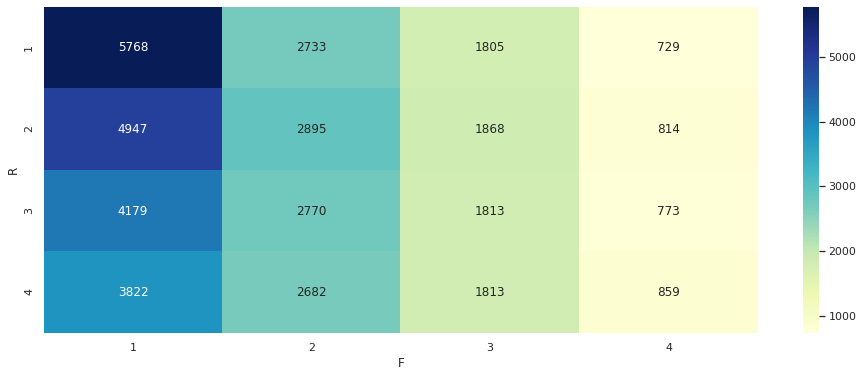

In [12]:
sns.heatmap(rfm_table, cmap="YlGnBu", annot=True, fmt=".0f");